In [2]:
# EXECUTE THE FOLLOWING STATEMENTS ONLY IF YOU ARE RUNNING ON AWS SAGEMAKER STUDIO
!cd .. && make install_on_sagemaker

pip3 install pipenv
  Using cached pipenv-2022.7.4-py2.py3-none-any.whl (3.7 MB)
  Using cached virtualenv-20.15.1-py2.py3-none-any.whl (10.1 MB)
  Using cached virtualenv_clone-0.5.7-py3-none-any.whl (6.6 kB)
  Using cached platformdirs-2.5.2-py3-none-any.whl (14 kB)
  Using cached filelock-3.7.1-py3-none-any.whl (10 kB)
  Using cached distlib-0.3.5-py2.py3-none-any.whl (466 kB)
pipenv install
Installing dependencies from Pipfile.lock (bb774e)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.
pipenv lock -r > /tmp/pipenv-requirements.txt
of pipenv in favor of the new requirements command. For more info see
https://pipenv.pypa.io/en/latest/advanced/#generating-a-requirements-txt
NOTE: the requirements command parses Pipfile.lock directly without performing any
locking operations. Updating packages should be done by running pipenv lock.
pip3 install -r /tmp

In [16]:
import os
from pathlib import Path

if os.getenv("ENVIRONMENT_NAME") != "local":
    os.chdir(Path().resolve().parent)

if os.getenv("ENVIRONMENT_NAME") == "local":
    os.environ["AWS_PROFILE"] = "datascience"

In [18]:
print("Current working directory (should be equal to the project root path):", os.getcwd())

Current working directory (should be equal to the project root path): /root/car-azimuth-predictor-experimentation


In [24]:
import src

In [26]:
########################################################
# USE THIS CODE ALWAYS AS FIRST CELL IN YOUR NOTEBOOKS #
########################################################

# DO NOT MODIFY THIS CODE
import sys
from pathlib import Path
sys.path.insert(0,str(Path(os.getcwd()).resolve()))
import os

from car_azimuth_predictor.config import load_config
load_config()
from car_azimuth_predictor.config import current_config

########################################################

In [ ]:
# TODO: Add your code here

In [27]:
from car_azimuth_predictor.data_gathering import collect_data

collect_data(current_config)

Save the output to /root/car-azimuth-predictor-experimentation/data/raw


In [28]:
from car_azimuth_predictor.feature_generation import generate_features

generate_features(current_config)

100%|██████████| 5475/5475 [00:15<00:00, 356.29it/s]


In [29]:
from car_azimuth_predictor.split_dataset import split_dataset

split_dataset(current_config)

## Approach 1
Output 2 variables (sin, cos), MSE loss 

In [ ]:
import tensorflow as tf

from src.utils.training_tools import (
    tf_mean_absolute_angle_error_sin_cos_output,
    tf_rmse_angle_sin_cos_output,
    tf_r2_angle_score_sin_cos_output,
    tf_median_absolute_angle_error_sin_cos_output,
    tf_acc_pi_6_sin_cos_output,
    horizontal_flip_pose_sin_cos_output
)

In [ ]:
from src.dataset_generation import generate_datasets

gt_cols = ['azimuth_sin', 'azimuth_cos']
train_dataset, validation_dataset, test_dataset = generate_datasets(current_config, gt_cols=gt_cols, pose_flip_fn=horizontal_flip_pose_sin_cos_output)

In [ ]:
input_layer = tf.keras.layers.Input(shape=(1280,))

mlp_middle = tf.keras.layers.Dense(32, activation='relu', name='mlp_middle')(input_layer)
mlp_output = tf.keras.layers.Dense(2, activation='tanh', name='mlp_output')(mlp_middle)

bottom = tf.keras.models.Model(inputs=input_layer, outputs=mlp_output)

In [ ]:
from src.model_generation import generate_model

model = generate_model(current_config, bottom=bottom)

In [ ]:
model.summary()

In [ ]:
loss = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
metrics=[
    tf_mean_absolute_angle_error_sin_cos_output,
    tf_rmse_angle_sin_cos_output,
    tf_r2_angle_score_sin_cos_output,
    tf_median_absolute_angle_error_sin_cos_output,
    tf_acc_pi_6_sin_cos_output
]
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)

In [ ]:
from src.train_model import train_model

train_history, current_datetime_strgfied = train_model(current_config, model=model, train_dataset=train_dataset, validation_dataset=validation_dataset, optimizer=optimizer, loss=loss, metrics=metrics, persist_train_history=True)

In [ ]:
from src.plot_training_curves import plot_training_curves

plot_training_curves(train_history, "Training curves - Approach 1. MeanSquaredError")

In [ ]:
from src.evaluate_model import evaluate_model
import tensorflow_hub as hub

custom_objects = {
    "KerasLayer": hub.KerasLayer,
    "tf_mean_absolute_angle_error_sin_cos_output": tf_mean_absolute_angle_error_sin_cos_output,
    "tf_rmse_angle_sin_cos_output": tf_rmse_angle_sin_cos_output,
    "tf_r2_angle_score_sin_cos_output": tf_r2_angle_score_sin_cos_output,
    "tf_median_absolute_angle_error_sin_cos_output": tf_median_absolute_angle_error_sin_cos_output,
    "tf_acc_pi_6_sin_cos_output": tf_acc_pi_6_sin_cos_output
}

current_datetime_strgfied = "20220715-093435"
evaluate_model(current_config, current_datetime_strgfied, 36, test_dataset, custom_objects)

## Approach 2
Output 2 variables (sin, cos), Cosine Similarity loss 

In [ ]:
import tensorflow as tf

from src.utils.training_tools import (
    tf_mean_absolute_angle_error_sin_cos_output,
    tf_rmse_angle_sin_cos_output,
    tf_r2_angle_score_sin_cos_output,
    tf_median_absolute_angle_error_sin_cos_output,
    tf_acc_pi_6_sin_cos_output,
    horizontal_flip_pose_sin_cos_output
)
from src.dataset_generation import generate_datasets

gt_cols = ['azimuth_sin', 'azimuth_cos']
train_dataset, validation_dataset, test_dataset = generate_datasets(current_config, gt_cols=gt_cols, pose_flip_fn=horizontal_flip_pose_sin_cos_output)
input_layer = tf.keras.layers.Input(shape=(1280,))

mlp_middle = tf.keras.layers.Dense(32, activation='relu', name='mlp_middle')(input_layer)
mlp_output = tf.keras.layers.Dense(2, activation='tanh', name='mlp_output')(mlp_middle)

bottom = tf.keras.models.Model(inputs=input_layer, outputs=mlp_output)

In [ ]:
from src.model_generation import generate_model

model = generate_model(current_config, bottom=bottom)

In [ ]:
loss = tf.keras.losses.CosineSimilarity()
metrics = [
    tf_mean_absolute_angle_error_sin_cos_output,
    tf_rmse_angle_sin_cos_output,
    tf_r2_angle_score_sin_cos_output,
    tf_median_absolute_angle_error_sin_cos_output,
    tf_acc_pi_6_sin_cos_output
]
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)

In [ ]:
from src.train_model import train_model

train_history, current_datetime_strgfied = train_model(current_config, model=model, train_dataset=train_dataset,
                                           validation_dataset=validation_dataset, optimizer=optimizer, loss=loss,
                                           metrics=metrics, persist_train_history=True)

In [ ]:
from src.plot_training_curves import plot_training_curves

plot_training_curves(train_history, "Training curves - Approach 2. CosineSimilarity")

In [ ]:
from src.evaluate_model import evaluate_model
import tensorflow_hub as hub
custom_objects = {
    "KerasLayer": hub.KerasLayer,
    "tf_mean_absolute_angle_error_sin_cos_output": tf_mean_absolute_angle_error_sin_cos_output,
    "tf_rmse_angle_sin_cos_output": tf_rmse_angle_sin_cos_output,
    "tf_r2_angle_score_sin_cos_output": tf_r2_angle_score_sin_cos_output,
    "tf_median_absolute_angle_error_sin_cos_output": tf_median_absolute_angle_error_sin_cos_output,
    "tf_acc_pi_6_sin_cos_output": tf_acc_pi_6_sin_cos_output
}

current_datetime_strgfied = "20220715-095559"
evaluate_model(current_config, current_datetime_strgfied, 8, test_dataset, custom_objects=custom_objects)

## Approach 3
Output 2 variable (angle from 0 to pi, angle from pi/2 to 3/2 pi), Custom crossentropy loss

In [3]:
import tensorflow as tf
input_layer = tf.keras.layers.Input(shape=(1280,))

mlp_middle = tf.keras.layers.Dense(
    32, activation="relu", name="mlp_middle"
)(input_layer)

angle1_sigmoid_output = tf.keras.layers.Dense(
    1, activation="sigmoid", name="angle1_output"
)(mlp_middle)
angle2_sigmoid_output = tf.keras.layers.Dense(
    1, activation="sigmoid", name="angle2_output"
)(mlp_middle)

# concatenate two together
angle_concatenated = tf.keras.layers.Concatenate(
    axis=1, name="concatenate_angles_2_vars"
)([angle1_sigmoid_output, angle2_sigmoid_output])

bottom = tf.keras.models.Model(inputs=input_layer, outputs=angle_concatenated)

2022-07-15 10:10:54.720153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:10:54.727183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:10:54.727806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 10:10:54.729331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [4]:
from src.model_generation import generate_model

model = generate_model(current_config, bottom=bottom)

In [5]:
from src.dataset_generation import generate_datasets
from src.utils.training_tools import (
    angle_double_output_loss,
    tf_acc_pi_6_double_sigmoid,
    tf_mean_absolute_angle_error_double_sigmoid,
    tf_median_absolute_angle_error_double_sigmoid,
    tf_r2_angle_score_double_sigmoid,
    tf_rmse_angle_score_double_sigmoid,
    horizontal_flip_pose_double_sigmoid
)

gt_cols = ['azimuth_norm_abs', 'azimuth_radians_shifted_0.5_pi_norm_abs']
train_dataset, validation_dataset, test_dataset = generate_datasets(current_config, gt_cols=gt_cols, pose_flip_fn=horizontal_flip_pose_double_sigmoid)

In [6]:

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
loss = angle_double_output_loss
metrics = [
    tf_mean_absolute_angle_error_double_sigmoid,
    tf_median_absolute_angle_error_double_sigmoid,
    tf_r2_angle_score_double_sigmoid,
    tf_rmse_angle_score_double_sigmoid,
    tf_acc_pi_6_double_sigmoid,
]

In [7]:
from src.train_model import train_model

train_history, current_datetime_strgfied = train_model(current_config, model=model, train_dataset=train_dataset, validation_dataset=validation_dataset, optimizer=optimizer, loss=loss, metrics=metrics)

Saving models' checkpoints to /root/car-azimuth-predictor-experimentation/saved_models/20220715-101105
Epoch 1/80


2022-07-15 10:11:18.245803: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


120/120 [==============================] - 41s 210ms/step - loss: 1.2716 - tf_mean_absolute_angle_error_double_sigmoid: 51.3706 - tf_median_absolute_angle_error_double_sigmoid: 37.7598 - tf_r2_angle_score_double_sigmoid: 0.2304 - tf_rmse_angle_score_double_sigmoid: 69.0685 - tf_acc_pi_6_double_sigmoid: 0.4702 - val_loss: 1.1980 - val_tf_mean_absolute_angle_error_double_sigmoid: 34.4806 - val_tf_median_absolute_angle_error_double_sigmoid: 17.8024 - val_tf_r2_angle_score_double_sigmoid: 0.5679 - val_tf_rmse_angle_score_double_sigmoid: 52.2521 - val_tf_acc_pi_6_double_sigmoid: 0.6440
Epoch 2/80
120/120 [==============================] - 23s 187ms/step - loss: 1.1511 - tf_mean_absolute_angle_error_double_sigmoid: 26.4933 - tf_median_absolute_angle_error_double_sigmoid: 13.5785 - tf_r2_angle_score_double_sigmoid: 0.7000 - tf_rmse_angle_score_double_sigmoid: 42.3167 - tf_acc_pi_6_double_sigmoid: 0.7416 - val_loss: 1.0963 - val_tf_mean_absolute_angle_error_double_sigmoid: 16.6630 - val_tf_med

In [8]:
import json

histories_path = "/root/car-azimuth-predictor-experimentation/training_histories"
os.makedirs(histories_path, exist_ok=True)
with open(os.path.join(histories_path, "approach_3_patience10.json"), "w") as fp:
    json.dump(train_history.history, fp)

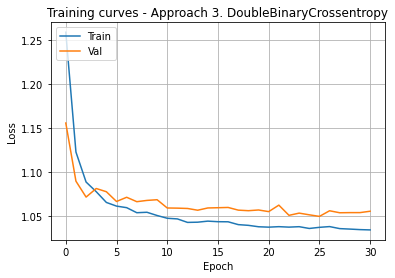

In [9]:
from src.plot_training_curves import plot_training_curves
import json

history_path = "/root/car-azimuth-predictor-experimentation/training_histories/approach_3.json"
with open(history_path, "r") as fp:
    train_history = json.load(fp)
plot_training_curves(train_history, "Training curves - Approach 3. DoubleBinaryCrossentropy")

In [12]:
from src.evaluate_model import evaluate_model
import tensorflow_hub as hub

custom_objects = {
    "KerasLayer": hub.KerasLayer,
    "angle_double_output_loss": angle_double_output_loss,
    "tf_mean_absolute_angle_error_double_sigmoid": tf_mean_absolute_angle_error_double_sigmoid,
    "tf_rmse_angle_score_double_sigmoid": tf_rmse_angle_score_double_sigmoid,
    "tf_r2_angle_score_double_sigmoid": tf_r2_angle_score_double_sigmoid,
    "tf_median_absolute_angle_error_double_sigmoid": tf_median_absolute_angle_error_double_sigmoid,
    "tf_acc_pi_6_double_sigmoid": tf_acc_pi_6_double_sigmoid
}

current_datetime_strgfied = "20220715-101105"
model, _ = evaluate_model(current_config, current_datetime_strgfied, 12, test_dataset, custom_objects=custom_objects)

Found /root/car-azimuth-predictor-experimentation/saved_models/20220715-101105/mobilenet.12-1.05.h5. Loading and evaluating it...
26/26 [==============================] - 3s 66ms/step - loss: 1.0481 - tf_mean_absolute_angle_error_double_sigmoid: 8.2113 - tf_median_absolute_angle_error_double_sigmoid: 3.7152 - tf_r2_angle_score_double_sigmoid: 0.9407 - tf_rmse_angle_score_double_sigmoid: 17.6870 - tf_acc_pi_6_double_sigmoid: 0.9603


In [15]:
len(os.listdir("/root/car-azimuth-predictor-experimentation/data/raw/PASCAL3D+_release1.1/Images/car_imagenet"))

5475

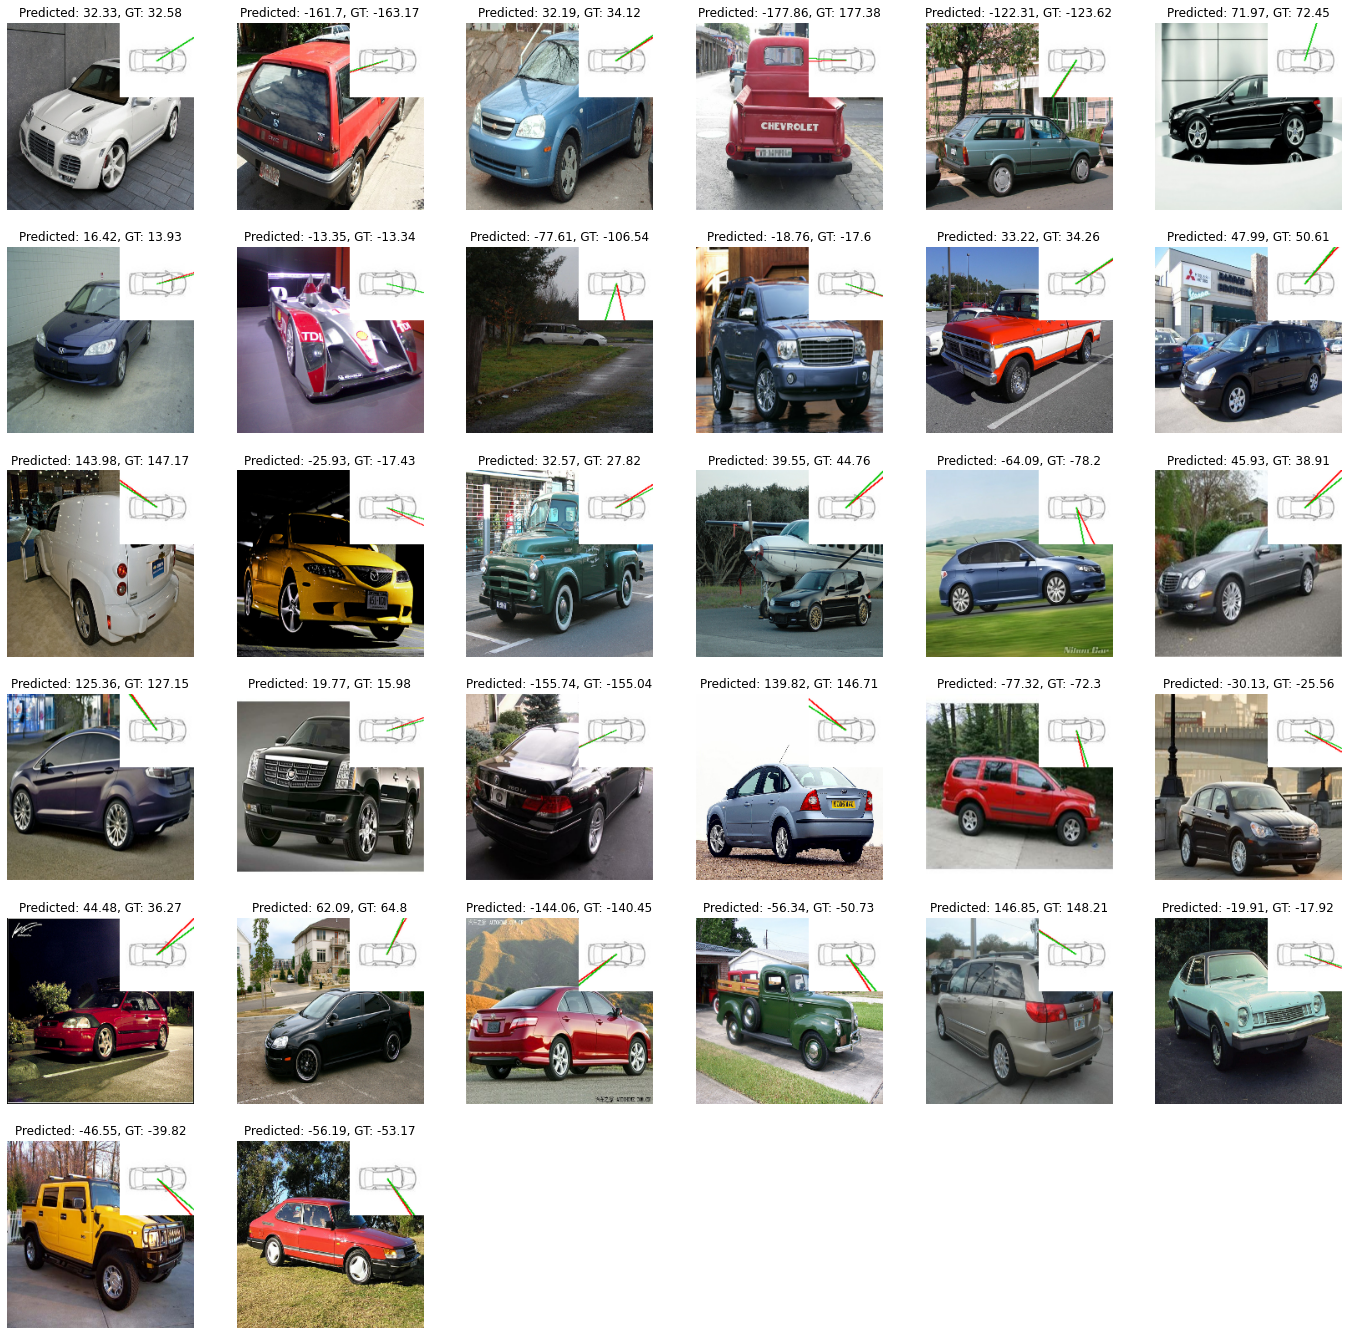

In [8]:
from src.visualize import visualize_predictions

visualize_predictions(model, test_dataset)

## Random experimentations and plots

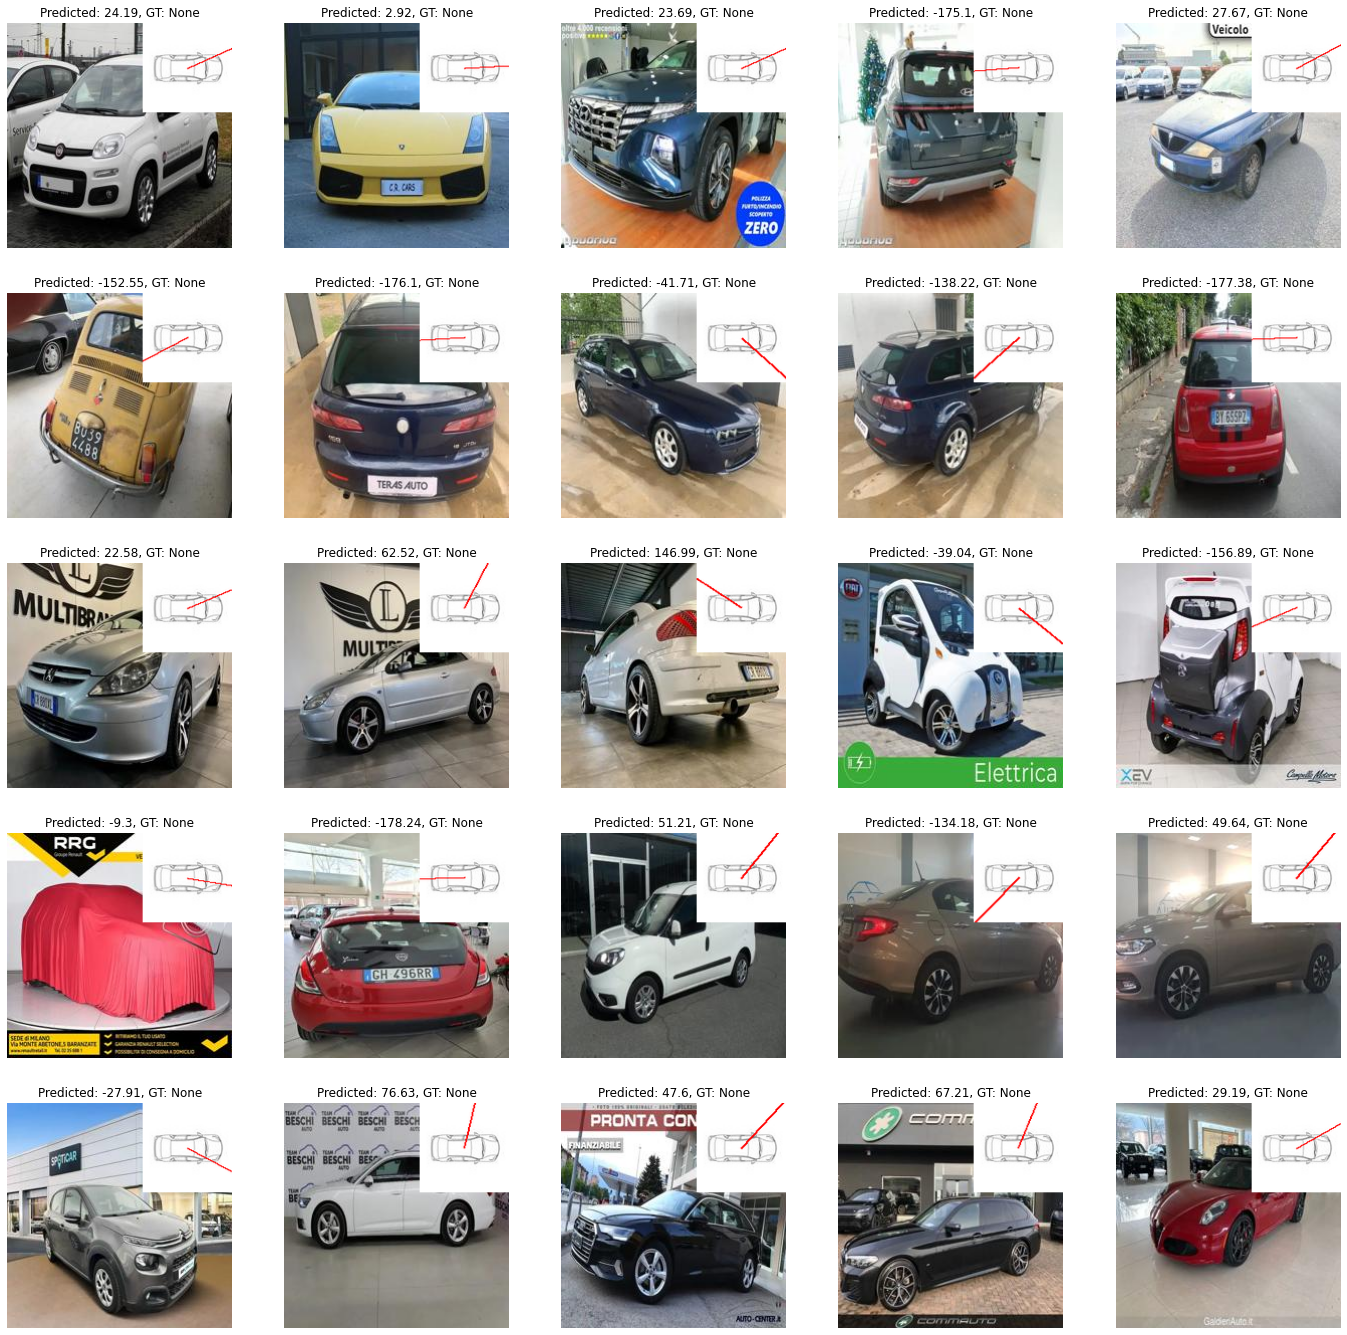

In [18]:
import requests
import io
import tempfile
import matplotlib.pyplot as plt
import math
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet_v2 import (
    preprocess_input as preprocess_input_effnet,
)
from src.utils.training_tools import np_get_angle_from_double_sigmoids
from src.utils.visualization_tools import plot_image_from_path


urls = [
    'https://upload.wikimedia.org/wikipedia/commons/6/6b/Fiat_Panda_1.2_8V_Lounge_%28III%29_%E2%80%93_Frontansicht_%281%29%2C_25._Februar_2012%2C_D%C3%BCsseldorf.jpg',
    'https://prod.pictures.autoscout24.net/listing-images/6bfcbee3-287c-c936-e043-1250030acba4_8fc165c2-c4ac-4b7e-839d-d8493643d946.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/3802d738-e48b-4d83-8591-91909d46364c_a62d9238-0abf-459e-bf5e-adb0adbf518c.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/3802d738-e48b-4d83-8591-91909d46364c_c42ff950-03eb-4453-b05f-66712e334045.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/7c46ed9c-2a35-4a0d-9cb4-dd580ab3a06a_76e97c5d-bc23-4e32-bd82-1faf05820772.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/5d998939-3d32-4f30-ba6a-0b7be9b7417e_9b2ada8b-83d7-4e60-8372-6caf4f773e28.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/91cd3f2d-ad89-4d9a-ab62-29a575fd3403_6211ebb0-6a30-44f7-9281-85d9396c6057.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/91cd3f2d-ad89-4d9a-ab62-29a575fd3403_2be35d4c-b029-4a8e-a051-b4bf98d5c6d8.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/91cd3f2d-ad89-4d9a-ab62-29a575fd3403_1ebcd7cc-c2e1-4f12-91a1-4e569d4fe723.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/8bc04ac1-b48c-4c21-9cd5-7f7f2c9d0fcd_00b68deb-3f96-44c8-bcf0-6e6c55ad2135.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/83af03db-5170-4778-8ab8-13a7d3dbf31a_986b9ca3-adda-44a9-84d6-9c35d09fcc6e.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/83af03db-5170-4778-8ab8-13a7d3dbf31a_bf251591-e5e3-4c57-9fdd-53c9ce10ee96.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/83af03db-5170-4778-8ab8-13a7d3dbf31a_62a1aee8-a4f9-400d-b343-889df15fe389.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/e74fc24f-2f2b-4219-812f-2fa43dc2e923_2c1f525f-2ecc-4bef-aae8-0c9ad8e650f4.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/e74fc24f-2f2b-4219-812f-2fa43dc2e923_a267a0c3-7672-4088-ac68-c26c7f429f82.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/677f431e-7478-4828-9cca-f6c4d9ae96f1_079d9bb9-8093-4e11-a991-873be527cbe8.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/e31139cf-5c92-4cd4-82e9-0fcd530c94f7_34c8865c-0465-4450-aa7b-41faf53826e5.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/b65fc27b-ad27-4e66-ace1-ac2742464eca_9e7e66db-adef-493b-a472-e402cc918685.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/f12d0232-111f-4887-a9eb-112f91c3efe5_5fe3939e-b81b-4f18-a4d3-ee7b5858dbfc.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/f12d0232-111f-4887-a9eb-112f91c3efe5_870664b6-23aa-464d-b481-9f6ec883fca8.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/8f5ac529-c8f4-408d-a3ac-664e967bf409_2b4dceb9-7d45-44c1-876e-5aecbb51dad7.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/8069a9b0-e78e-4cba-8e37-76437312534a_e563f624-0e7f-4d6e-9331-1edcf100b548.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/e8d79a2d-057f-45f3-a231-c17662d1175a_07c7315f-03a2-45f4-9fcb-7d8e6424e8dc.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/c939465c-7cfe-4ff2-b062-6ebff742c163_0d7c9145-33a5-4b21-be67-5d3e585a6148.jpg/720x540.webp',
    'https://prod.pictures.autoscout24.net/listing-images/62d6b64c-63ea-4fcf-b813-83945cb525f0_99254a7d-d4b0-4476-b683-78704a01cf8f.jpg/720x540.webp'

]

plt.figure(figsize=(24, 24))
square_size = int(math.ceil(math.sqrt(len(urls))))

for i, url in enumerate(urls):
    with tempfile.NamedTemporaryFile() as fp:

        res = requests.get(url, headers={'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}, stream=True)
        fp.write(res.raw.read())

        # virt_file.seek(0)
        img = Image.open(fp.name)
        img = img.resize([224, 224])
        img.save(fp.name + '.resized.jpg')


        X = np.array([preprocess_input_effnet(np.array(img))])

        y_pred = model.predict(X)

        # print(y_pred.shape)

        y_pred_degrees = np_get_angle_from_double_sigmoids(y_pred) / np.pi * 180


        # y_pred_angle = np.arctan2(y_pred[:, 0], y_pred[:, 1]) / math.pi * 180

        plt.subplot(square_size, square_size, i + 1)
        plot_image_from_path(fp.name + '.resized.jpg', float(y_pred_degrees[0]))

In [18]:
import tensorflow_hub as hub
from src.utils.training_tools import np_get_angle_from_double_sigmoids
import numpy as np


y_preds = []
y_gts = []

custom_objects = {
    "KerasLayer": hub.KerasLayer,
    "angle_double_output_loss": angle_double_output_loss,
    "tf_mean_absolute_angle_error_double_sigmoid": tf_mean_absolute_angle_error_double_sigmoid,
    "tf_rmse_angle_score_double_sigmoid": tf_rmse_angle_score_double_sigmoid,
    "tf_r2_angle_score_double_sigmoid": tf_r2_angle_score_double_sigmoid,
    "tf_median_absolute_angle_error_double_sigmoid": tf_median_absolute_angle_error_double_sigmoid,
    "tf_acc_pi_6_double_sigmoid": tf_acc_pi_6_double_sigmoid
}

current_datetime_strgfied = "20220715-101105"

model = tf.keras.models.load_model(
    "/root/car-azimuth-predictor-experimentation/saved_models/20220715-101105/mobilenet.12-1.05.h5",
    custom_objects=custom_objects,
)
for x, y_gt in test_dataset:
    y_pred = model(x).numpy()

    
    y_pred_angle = np_get_angle_from_double_sigmoids(y_pred)
    #y_pred_angle += np.pi
    y_pred_angle *= 180/np.pi
    
    y_gt = y_gt.numpy()
    y_gt_angle = np_get_angle_from_double_sigmoids(y_gt)
    #y_gt_angle += np.pi
    y_gt_angle *= 180/np.pi
    
    positive_cond = y_gt_angle - y_pred_angle >  180
    negative_cond = y_gt_angle - y_pred_angle < -180

    y_pred_angle += positive_cond * 360
    y_pred_angle -= negative_cond * 360
    residuals = y_gt_angle - y_pred_angle

    y_preds.extend(y_pred_angle)
    y_gts.extend(y_gt_angle)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Residuals', ylabel='Density'>

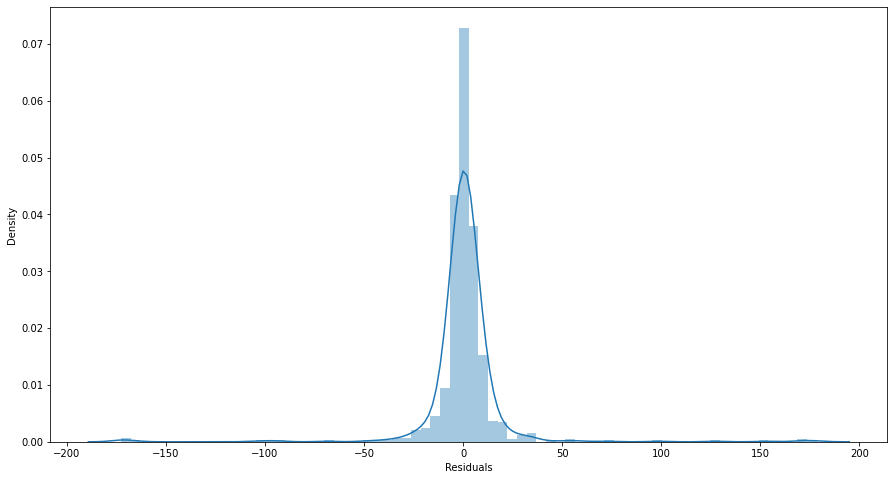

In [24]:
import matplotlib.pyplot as plt

y_gts = np.array(y_gts) 
y_preds = np.array(y_preds)

positive_cond = y_gts - y_preds >  180
negative_cond = y_gts - y_preds < -180
    
y_preds += positive_cond * 360
y_preds -= negative_cond * 360
residuals = y_gts - y_preds

import seaborn as sns

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1,)
ax.set_xlabel("Residuals")
sns.distplot(residuals, ax=ax, bins=72, kde=True)
# ax.set_xlabel("Angles")
# ax.set_ylabel("Density")
# import scipy.stats as stats

# mu = np.mean(residuals)
# sigma = np.std(residuals)
# x = np.linspace(-180, 180, 360)
# ax.plot(x, stats.norm.pdf(x, mu, sigma), color="red")
# plt.show()

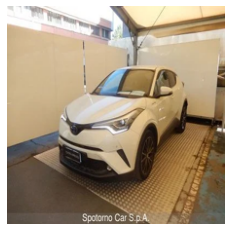

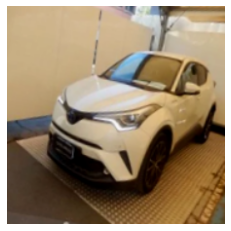

In [38]:
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt

transforms = A.Compose(
    [
        A.Rotate(limit=10, p=1),
        A.OpticalDistortion(distort_limit=(0, 0.2), p=0),
        A.RandomCrop(height=180, width=180, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1),
        A.Resize(*(224, 224), always_apply=True),
    ]
)

img = Image.open("/root/car-azimuth-predictor-experimentation/src/utils/1657014643883.webp")

img = img.resize((224,224))
aug_img = transforms(image=np.array(img))

aug_img = Image.fromarray(aug_img["image"])

plt.imshow(img)
plt.axis("off")
plt.show()
plt.imshow(aug_img)
plt.axis("off")
plt.show()